Titanic

# Setup

## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import random

from sklearn.model_selection import cross_val_score

In [2]:
np.random.seed(42)
random.seed(42)
TRAIN_PATH = "./data/train.csv"
IMAGES_PATH = "./images"

# Get the Data

In [3]:
def load_train_data(train_path=TRAIN_PATH):
    csv_path = train_path
    return pd.read_csv(csv_path)

data = load_train_data()

# Data Analysis

## An Overview of the Data

In [269]:
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Check the NULL values

In [5]:
info = data.isnull().sum()
info[info != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

These values must be filled with proper values latter on.

## Feature analysis

### `Survived` - target

In [8]:
data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### `Pclass` and `Sex` and `Embarked`

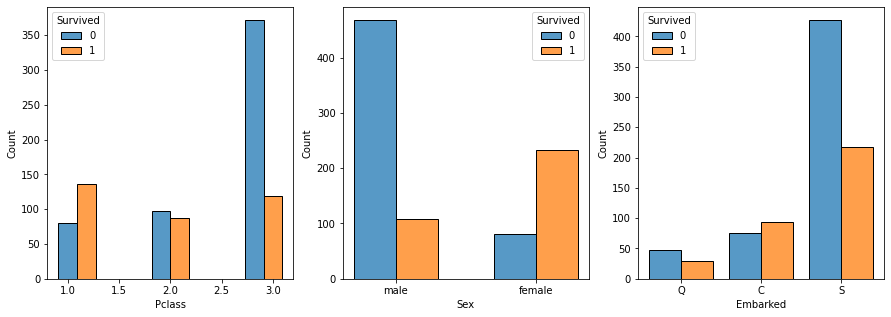

In [164]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(data=data, x="Pclass", hue="Survived", multiple="dodge", shrink=2.0)
plt.subplot(132)
sns.histplot(data=data, x="Sex", hue="Survived", multiple="dodge", shrink=.6)
plt.subplot(133)
sns.histplot(data=data, x="Embarked", hue="Survived", multiple="dodge", shrink=.8)
plt.savefig(IMAGES_PATH+'/Pclass_Sex_Embarked.png')

plt.show()

There exists a strong correlation between the survival chance and PClass, Sex, and the embarked Place.

### `Age`

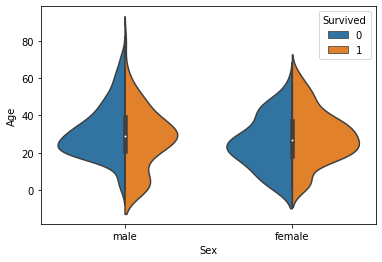

In [41]:
sns.violinplot(x ="Sex", y ="Age", hue ="Survived",data = data, split = True)
plt.show()

It seems that elder people are more likely to survive.

### `Fare`

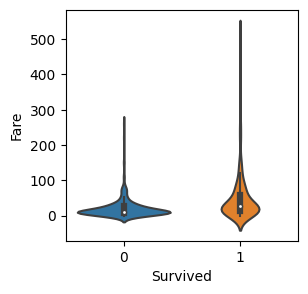

In [23]:
plt.rcParams["figure.figsize"] = (3, 3)
sns.violinplot(y="Fare", x="Survived", data=data, split=True)
plt.show()

The distribution is distorted by outliers, maybe hidden pattern would be better revealed after clip operation.

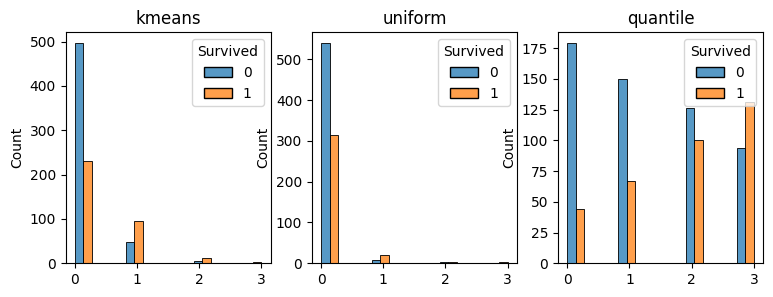

In [48]:
from sklearn.preprocessing import KBinsDiscretizer

stgs = ["kmeans", "uniform", "quantile"]
plt.rcParams["figure.figsize"] = (9, 3)
for i, stg in enumerate(stgs):
    est = KBinsDiscretizer(n_bins=4, strategy=stg, encode="ordinal")
    ords = est.fit_transform(data["Fare"].to_numpy().reshape((-1, 1)))

    plt.subplot(1, 3, i+1)
    plt.title(stg)
    sns.histplot(x=ords.reshape((-1, )), hue=data["Survived"], multiple="dodge")


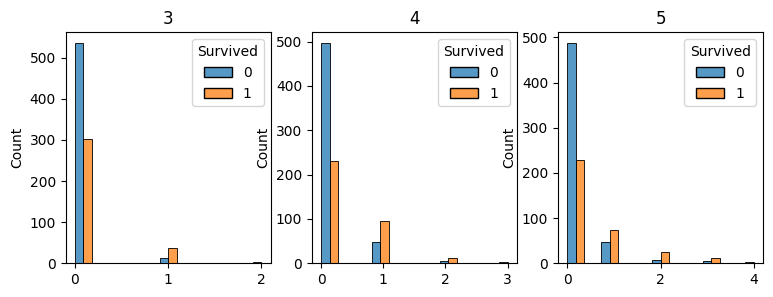

In [49]:
lstNumBins = [3, 4, 5]

plt.rcParams["figure.figsize"] = (9, 3)
for i, numBins in enumerate(lstNumBins):
    est = KBinsDiscretizer(n_bins=numBins, strategy="kmeans", encode="ordinal")
    ords = est.fit_transform(data["Fare"].to_numpy().reshape((-1, 1)))

    plt.subplot(1, 3, i+1)
    plt.title(numBins)
    sns.histplot(x=ords.reshape((-1, )), hue=data["Survived"], multiple="dodge")

It seems that using `KBinsDiscretizer` with n_bins=3 and strategy="kmeans" would be the best choice.

### `SibSp` and `Parch` - Family Members

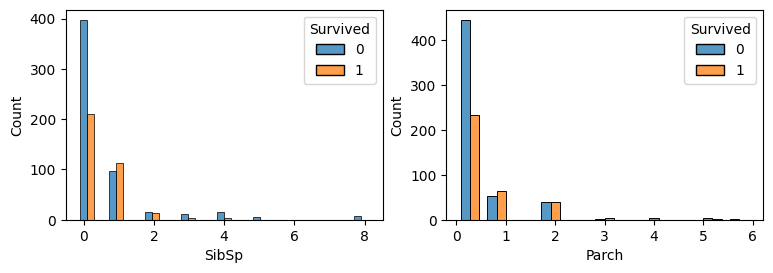

In [75]:
plt.figure(figsize=(9, 6))

plt.subplot(221)
sns.histplot(data=data, x="SibSp", hue="Survived", multiple="dodge", shrink=2)
plt.subplot(222)
sns.histplot(data=data, x="Parch", hue="Survived", multiple="dodge", shrink=0.7)

plt.show()

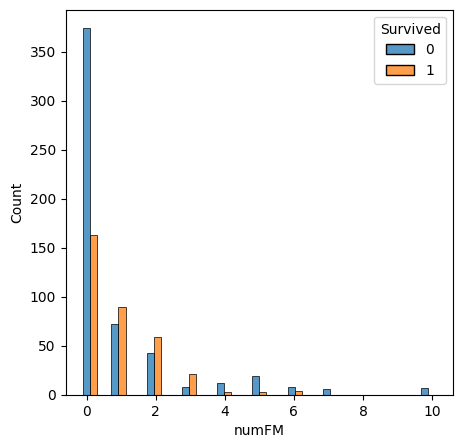

In [53]:
plt.figure(figsize=(5, 5))
data["numFM"] = data["SibSp"] + data["Parch"]
sns.histplot(data=data, x="numFM", hue="Survived", multiple="dodge", shrink=2)
plt.show()

Those who had no family or more than three family members with them are less likely to survive. It may be better to design a few categories. By observation we can see chance of surviving with number of family members with 0, 1-3, 4 and above show similar pattern.

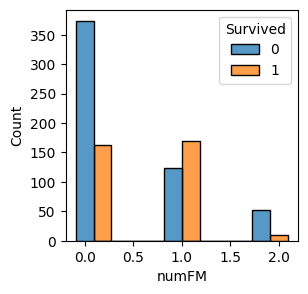

In [71]:
def process_numFM(x):
    if x == 0:
        return 0
    elif 1<=x<=3:
        return 1
    else:
        return 2

plt.figure(figsize=(3, 3))
data["numFM"] = data["SibSp"] + data["Parch"]
data["numFM"] = data["numFM"].apply(process_numFM)
sns.histplot(data=data, x="numFM", hue="Survived", multiple="dodge", shrink=2)
plt.show()

### Fill `Age`

First examine the relation between age and other features.

In [273]:
def get_Title(data: pd.DataFrame):
    titles = []
    for name in data["Name"].to_list():
        last_name = name.split(",")[1]
        title = last_name.split(".")[0]
        titles.append(title.replace(" ", ""))
    data["Title"] = titles

get_Title(data)

mask = data["Age"].isnull()
data_age = data[mask==0]

res = pd.concat(
    [
        data_age.groupby("Title")["Age"].mean(),
        data_age.groupby("Title")["Age"].count()
    ],
    axis=1,
)
res

,Age,Age
Title,,
Capt,70.000000,1
Col,58.000000,2
Don,40.000000,1
Dr,42.000000,6
Jonkheer,38.000000,1
Lady,48.000000,1
Major,48.500000,2
Master,4.574167,36
Miss,21.773973,146


Age does show different patterns with respect to title.

In [95]:
data_null_age = data[mask]
set(data_null_age["Title"])

{' Dr', ' Master', ' Miss', ' Mr', ' Mrs'}

Missing of age only occurs in above groups.

Let's try build a random forest regressor for `Age`, with features including `Title`, `Sex`, `Family_Members`, and `Fare`.

Prepare data

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

dis_attribs = ["Fare"]
cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "Title"]

data_with_age = data[data["Age"].isna() == 0]

full_pipeline = ColumnTransformer([
    ("dis", KBinsDiscretizer(n_bins=3, strategy="kmeans", encode="ordinal"), dis_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

X = full_pipeline.fit_transform(data_with_age)
y = data_with_age["Age"].to_numpy()

Linear Model

In [81]:
from sklearn.linear_model import LinearRegression

rgr = LinearRegression()
score = cross_val_score(rgr, X, y, cv=5)
score.mean()

-6.551539993840813e+23

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    "max_depth": list(range(6, 12)),
    # "max_features": list(range(5, 25)), # range \in (0, n_features]
    "max_leaf_nodes": list(range(10, 35)),
}

regr = RandomForestRegressor()
search = RandomizedSearchCV(
    estimator=regr, param_distributions=params,
    n_iter=50, cv=5, n_jobs=4,
)
search.fit(X, y)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

best parameters:  {'n_estimators': 100, 'max_leaf_nodes': 11, 'max_depth': 7}
best scores:  0.41253172517476155


Random Forest

It turns out to be quite hard to predict age with other information.

# Regressor or Median for missing `Age`?

## Median

Fill na with mean of each group and other with overall mean.

In [538]:
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


def get_Title(data: pd.DataFrame):
    titles = []
    for name in data["Name"].to_list():
        last_name = name.split(",")[1]
        title = last_name.split(".")[0]
        titles.append(title.replace(" ", ""))
    data["Title"] = titles


def fill_age(row, age_dict):
    if np.isnan(row["Age"]):
        row["Age"] = age_dict[row["transTitle"]]
    return row


def get_features(data: pd.DataFrame):
    # get new feature `Title``
    get_Title(data)

    # get rows with age 
    age_mask = data["Age"].isnull()
    data_with_age = data[age_mask==0]

    # count instances of each age group
    counter_dict = data_with_age.groupby("Title")["Age"].count().to_dict()
    # only keep age group with more than 5 instances and divide the remaining as other
    func = lambda x: x if counter_dict[x] > 5 else "Other"
    # transform Title
    data_with_age = data_with_age.assign(transTitle=data_with_age["Title"].apply(func))
    data = data.assign(transTitle=data["Title"].apply(func))
    # dict storing mean of each age group
    age_dict = data_with_age.groupby("transTitle")["Age"].mean().to_dict()
    data["Age"] = data.apply(fill_age, axis=1, age_dict=age_dict)["Age"]

    data["numFM"] = data["SibSp"] + data["Parch"]
    return data

num_attribs = ["Age", "Fare"]
cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "transTitle"]

full_pipeline = ColumnTransformer([
    ("num", "passthrough", num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

data = load_train_data()
data = get_features(data)
data = shuffle(data, random_state=42)
data.reset_index(inplace=True, drop=True)

X = full_pipeline.fit_transform(data)
y = data["Survived"].to_numpy()

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1e3)
score = cross_val_score(clf, X, y, cv=5)
score.mean()

0.8260498399347185

In [8]:
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


def get_Title(data: pd.DataFrame):
    titles = []
    for name in data["Name"].to_list():
        last_name = name.split(",")[1]
        title = last_name.split(".")[0]
        titles.append(title.replace(" ", ""))
    data["Title"] = titles
    Title_Dict={}
    Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
    Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
    Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
    Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
    Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
    Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
    data["Title"] = data["Title"].map(Title_Dict)


def fill_age_regr(row, age_dict):
    if np.isnan(row["Age"]):
        row["Age"] = age_dict[row["transTitle"]]
    return row


def get_features(data: pd.DataFrame):
    # get new feature `Title``
    get_Title(data)
    # get new feature `numFM`
    data["numFM"] = data["SibSp"] + data["Parch"]

    # get rows with age 
    nan_mask = data["Age"].isnull()
    data_with_age = data[nan_mask==0]
    
    num_attribs = ["Fare"]
    cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "Title"]

    pipeline = ColumnTransformer([
        ("num", "passthrough", num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
    
    X = pipeline.fit_transform(data)
    y = data_with_age["Age"].to_numpy()

    return X[nan_mask==0], X[nan_mask==1], y
    

data = load_train_data()
X_train, X_test, y_train = get_features(data)

In [10]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
score = cross_val_score(regr, X_train, y_train, cv=5)
score.mean()

0.3989525377959512

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    "max_depth": list(range(6, 12)),
    "max_leaf_nodes": list(range(10, 35)),
}

regr = RandomForestRegressor()
search = RandomizedSearchCV(
    estimator=regr, param_distributions=params,
    n_iter=50, cv=5, n_jobs=4, verbose=1,
)
search.fit(X_train, y_train)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters:  {'n_estimators': 500, 'max_leaf_nodes': 10, 'max_depth': 8}
best scores:  0.4101256016531359


In [ ]:

num_attribs = ["Age", "Fare"]
cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "transTitle"]

full_pipeline = ColumnTransformer([
    ("num", "passthrough", num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

data = load_train_data()
data = get_features(data)
data = shuffle(data, random_state=42)
data.reset_index(inplace=True, drop=True)

X = full_pipeline.fit_transform(data)
y = data["Survived"].to_numpy()

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1e3)
score = cross_val_score(clf, X, y, cv=5)
score.mean()

## Regressor

In [541]:
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression


def get_Title(data: pd.DataFrame):
    titles = []
    for name in data["Name"].to_list():
        last_name = name.split(",")[1]
        title = last_name.split(".")[0]
        titles.append(title.replace(" ", ""))
    data["Title"] = titles
    return data


def prepare_regressor_data(data: pd.DataFrame):
    # get new feature `numFM`
    data["numFM"] = data["SibSp"] + data["Parch"]
    # get new feature `Title``
    get_Title(data)

    # get rows with age 
    nan_mask = data["Age"].isnull()
    data_with_age = data[nan_mask==0]

    # count instances of each age group
    counter_dict = data_with_age.groupby("Title")["Age"].count().to_dict()
    # only keep age group with more than 5 instances and divide the remaining as other
    func = lambda x: x if counter_dict[x] > 5 else "Other"
    # transform Title
    data_with_age = data_with_age.assign(transTitle=data_with_age["Title"].apply(func))
    data = data.assign(transTitle=data["Title"].apply(func))

    num_attribs = ["Fare"]
    cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "transTitle"]

    pipeline = ColumnTransformer([
        ("num", "passthrough", num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
    
    X = pipeline.fit_transform(data)
    y = data_with_age["Age"].to_numpy()

    return X[nan_mask==0], X[nan_mask==1], y

data = load_train_data()
X_train, X_test, y_train = prepare_regressor_data(data)

In [542]:
reg = LinearRegression()
score = cross_val_score(reg, X_train, y_train, cv=5)
score.mean()

0.3975771006852229

In [543]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    "max_depth": list(range(6, 12)),
    # "max_features": list(range(5, 25)), # range \in (0, n_features]
    "max_leaf_nodes": list(range(10, 35)),
}

regr = RandomForestRegressor()
search = RandomizedSearchCV(
    estimator=regr, param_distributions=params,
    n_iter=50, cv=5, n_jobs=4, verbose=1,
)
search.fit(X_train, y_train)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters:  {'n_estimators': 300, 'max_leaf_nodes': 10, 'max_depth': 9}
best scores:  0.4094451928563537


In [559]:
def fill_age_reg(row, reg, pipeline):
    if np.isnan(row["Age"]):
        # X = pipeline.fit_transform(row)
        print(row)
        # row["Age"] = reg.predict(X)
    return row
    

def get_features(data: pd.DataFrame):
    # get new feature `numFM`
    data["numFM"] = data["SibSp"] + data["Parch"]
    # get new feature `Title``
    get_Title(data)

    # get rows with age 
    nan_mask = data["Age"].isnull()
    data_with_age = data[nan_mask==0]

    # count instances of each age group
    counter_dict = data_with_age.groupby("Title")["Age"].count().to_dict()
    # only keep age group with more than 5 instances and divide the remaining as other
    func = lambda x: x if counter_dict[x] > 5 else "Other"
    # transform Title
    data_with_age = data_with_age.assign(transTitle=data_with_age["Title"].apply(func))
    data = data.assign(transTitle=data["Title"].apply(func))

    num_attribs = ["Fare"]
    cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "transTitle"]

    pipeline = ColumnTransformer([
        ("num", "passthrough", num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
    
    X = pipeline.fit_transform(data)
    y = data_with_age["Age"].to_numpy()

    reg = RandomForestRegressor(
        n_estimators=300,
        max_leaf_nodes=12,
        max_depth=10,
    ).fit(X[nan_mask==0], y)
    print(f"Fit score of linear age regressor: {reg.score(X[nan_mask==0], y):.3f}")
    pred_age = pd.Series(
        data=reg.predict(X[nan_mask==1]),
        index=nan_mask[nan_mask].index
    )
    data["Age"].fillna(pred_age, inplace=True)
    return data

num_attribs = ["Fare", "Age"]
cat_attribs = ["Pclass", "Sex", "numFM", "Embarked", "transTitle"]

full_pipeline = ColumnTransformer([
    ("num", "passthrough", num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

data = load_train_data()
data = get_features(data)
data = shuffle(data, random_state=42)
data.reset_index(inplace=True, drop=True)

X = full_pipeline.fit_transform(data)
y = data["Survived"].to_numpy()

reg = LogisticRegression(max_iter=1000)
score = cross_val_score(reg, X, y, cv=5)
score.mean()

Fit score of linear age regressor: 0.483


0.8282907538760907

In [560]:
X.shape

(891, 27)

In [562]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    "max_depth": list(range(6, 12)),
    "max_leaf_nodes": list(range(10, 35)),
}

clf = RandomForestClassifier()
search = RandomizedSearchCV(
    estimator=clf, param_distributions=params,
    n_iter=50, cv=5, n_jobs=4, verbose=1,
)
search.fit(X, y)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters:  {'n_estimators': 200, 'max_leaf_nodes': 18, 'max_depth': 10}
best scores:  0.8316427091833531


## Logistic Regression (80.8%)

accuracy: 0.808


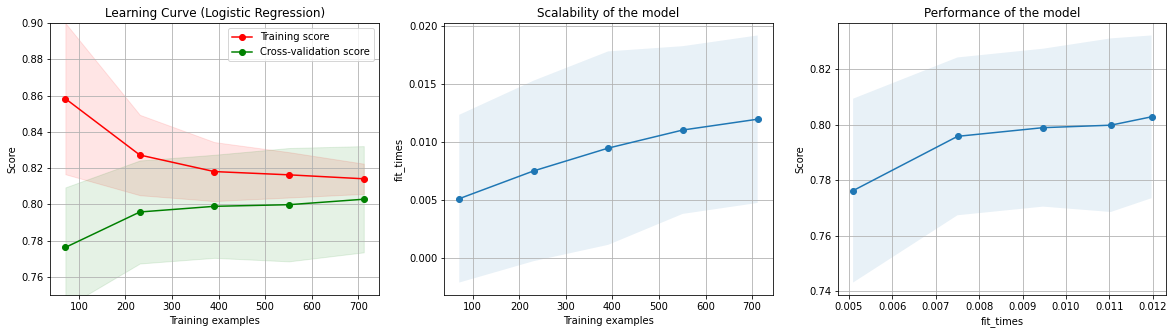

In [176]:
from sklearn.linear_model import LogisticRegression

data = load_train_data()

title = "Learning Curve (Logistic Regression)"
clf = LogisticRegression(random_state=42)

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
utils.plot.plot_learning_curve(
    clf, title, X, y, ylim=(0.75, 0.9), cv=cv, n_jobs=4
)

score = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
print('accuracy: %.3f'%score.mean())
plt.show()

## Decision Tree (83.2%)

accuracy: 0.785


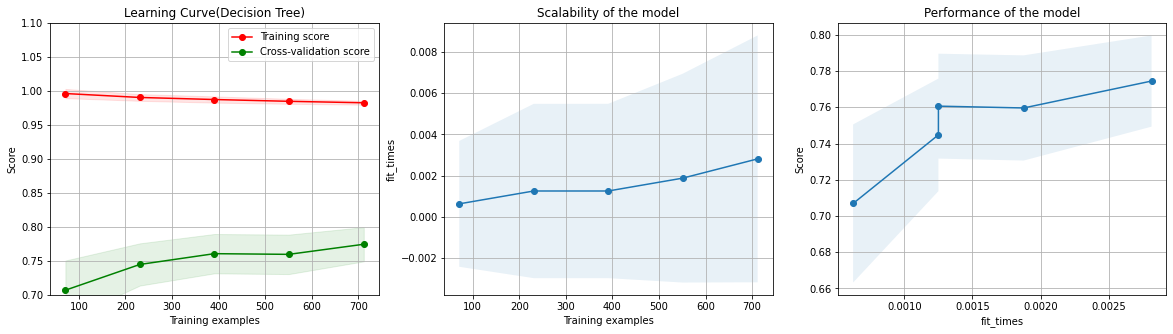

In [6]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier()

title = "Learning Curve(Decision Tree)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
utils.plot.plot_learning_curve(
    tree_clf, title, X, y, ylim=(0.7, 1.1), cv=cv, n_jobs=4
)
score = cross_val_score(tree_clf, X, y, scoring='accuracy', cv=5)
print('accuracy: %.3f'%score.mean())
plt.show()

strongly over fitted!

### GridSearch

In [50]:
X.shape

(891, 25)

In [7]:
from sklearn.model_selection import GridSearchCV

grid = {
    "max_depth": list(range(5, 10)),
    "max_features": list(range(1, 25)), # range \in (0, n_features]
    "max_leaf_nodes": list(range(2, 25)),
    "criterion": ['gini', 'entropy'],
}

clf = tree.DecisionTreeClassifier()
search = GridSearchCV(
    estimator=clf, param_grid = grid,
    cv=5, verbose=2, n_jobs = 4
    )
search.fit(X, y)
print('best parameters: ', search.best_params_)

Fitting 5 folds for each of 5520 candidates, totalling 27600 fits
best parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 13, 'max_leaf_nodes': 23}


In [8]:
search.best_score_

0.831648986253217

## SVM (82.8%)

`scipy.stats.expon(scale)`=$pdf=scale\cdot e^{-scale\cdot x}$

In [36]:
import scipy
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
params = {
    'C': scipy.stats.expon(scale=100),
    'gamma': scipy.stats.expon(scale=.1),
    'kernel': ['rbf'],
}
clf = SVC()
search = RandomizedSearchCV(
    estimator=clf, param_distributions=params,
    n_iter=100, cv=5
)
search.fit(X, y)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

best parameters:  {'C': 1.5813176556296222, 'gamma': 0.08589955934294802, 'kernel': 'rbf'}
best scores:  0.817048521750047


## Random Forest (83.7%)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    "max_depth": list(range(6, 12)),
    "max_features": list(range(5, 25)), # range \in (0, n_features]
    "max_leaf_nodes": list(range(10, 35)),
}

clf = RandomForestClassifier()
search = RandomizedSearchCV(
    estimator=clf, param_distributions=params,
    n_iter=50, cv=5, n_jobs=4, verbose=1,
)
search.fit(X, y)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters:  {'n_estimators': 400, 'max_leaf_nodes': 29, 'max_features': 23, 'max_depth': 8}
best scores:  0.8373046262004896


## Error analysis

In [ ]:
from sklearn.model_selection import cross_val_predict

In [35]:
params = {'criterion': 'gini', 'max_depth': 7, 'max_features': 13, 'max_leaf_nodes': 23}
best_tree_clf = tree.DecisionTreeClassifier(**params)
y_pred = cross_val_predict(best_tree_clf, X, y, cv=5)

errors_tree = data[y_pred != y]
errors_tree

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
9,403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
17,702,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
21,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
861,82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S
864,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S
876,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
884,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


In [37]:
params = {'C': 1.5813176556296222, 'gamma': 0.08589955934294802, 'kernel': 'rbf'}
best_SVM_clf = SVC(**params)
y_pred = cross_val_predict(best_SVM_clf, X, y, cv=5)

errors_SVM = data[y_pred != y]
errors_SVM

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,363,0,3,"Barbara, Mrs. (Catherine David)",female,45.0,0,1,2691,14.4542,NaN,C
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
17,702,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
21,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
864,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S
876,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
884,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


In [38]:
params = {'n_estimators': 400, 'max_leaf_nodes': 29, 'max_features': 23, 'max_depth': 8}
best_rndf_clf = RandomForestClassifier(**params)
y_pred = cross_val_predict(best_rndf_clf, X, y, cv=5)

errors_rndf = data[y_pred != y]
errors_rndf

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
21,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
46,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C
56,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
864,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S
874,550,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.7500,NaN,S
876,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
884,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


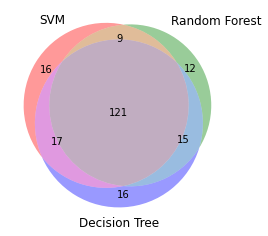

In [166]:
from matplotlib_venn import venn3

set1 = set(errors_SVM.index)
set2 = set(errors_rndf.index)
set3 = set(errors_tree.index)

venn3([set1, set2, set3], ('SVM', 'Random Forest', 'Decision Tree'))
plt.savefig(IMAGES_PATH+'/error_venn_plot.png')
plt.show()

All three classifiers make common mistakes at same instances, let's explore these instances.

In [82]:
def find_common_errors(errors):
    """
    Parameters
    ----------
    errors: a list of Dataframes containing mistaken instance
    Returns: Dataframe of common errors
    -------
    """
    list_idx = [np.array(i.index) for i in errors]
    idx = list_idx[0]
    # list(set(list1).intersection(list2))
    for i in list_idx:
        idx = list(set(i).intersection(idx))

    return idx

errors = [errors_tree, errors_SVM, errors_rndf]
common_idx = find_common_errors(errors)
common_errors = errors_tree.loc[common_idx]
common_errors

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
512,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
516,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S
519,703,0,3,"Barbara, Miss. Saiide",female,18.0,0,1,2691,14.4542,NaN,C
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
458,313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,NaN,S
470,126,1,3,"Nicola-Yarred, Master. Elias",male,12.0,1,0,2651,11.2417,NaN,C
488,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
493,824,1,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S


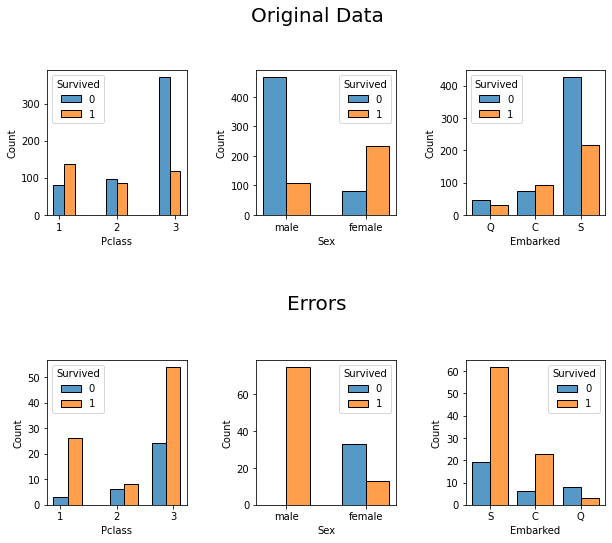

In [168]:
fig = plt.figure(figsize=(10, 8))

subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle('Original Data', fontsize=20)
subfigs[0].subplots(nrows=1, ncols=3, sharey=True, sharex=True)
plt.subplot(231)
sns.histplot(data=data, x="Pclass", hue="Survived", multiple="dodge", shrink=2.0)
plt.subplot(232)
sns.histplot(data=data, x="Sex", hue="Survived", multiple="dodge", shrink=.6)
plt.subplot(233)
sns.histplot(data=data, x="Embarked", hue="Survived", multiple="dodge", shrink=.8)

subfigs[1].suptitle('Errors', fontsize=20)
plt.subplot(234)
sns.histplot(data=common_errors, x="Pclass", hue="Survived", multiple="dodge", shrink=2.0)
plt.subplot(235)
sns.histplot(data=common_errors, x="Sex", hue="Survived", multiple="dodge", shrink=.6)
plt.subplot(236)
sns.histplot(data=common_errors, x="Embarked", hue="Survived", multiple="dodge", shrink=.8)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)
plt.savefig(IMAGES_PATH+'/two_distributions.png')
plt.show()

# Fill Missing `Age`

In [11]:
print('Missing %d Ages'%data.Age.isnull().sum())
data[data.Age.isnull()]

Missing 177 Ages


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


## Explore `Name`

In [15]:
print('Missing %d names'%data.Name.isnull().sum())

Missing 0 names


In [56]:
def get_title(data):
    np_names = np.array(data.Name)
    titles = []
    for name in np_names:
        family_name = name.split(',')[-1]
        title = family_name.split('.')[0]
        titles.append(title)

    set_titles = set(titles)
    data['title'] = titles

    return set_titles

set_titles = get_title(data)
print(set_titles)
data

{' Sir', ' Lady', ' Dr', ' Don', ' Ms', ' Rev', ' Mr', ' Miss', ' Col', ' Jonkheer', ' Master', ' Major', ' the Countess', ' Mrs', ' Capt', ' Mlle', ' Mme'}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


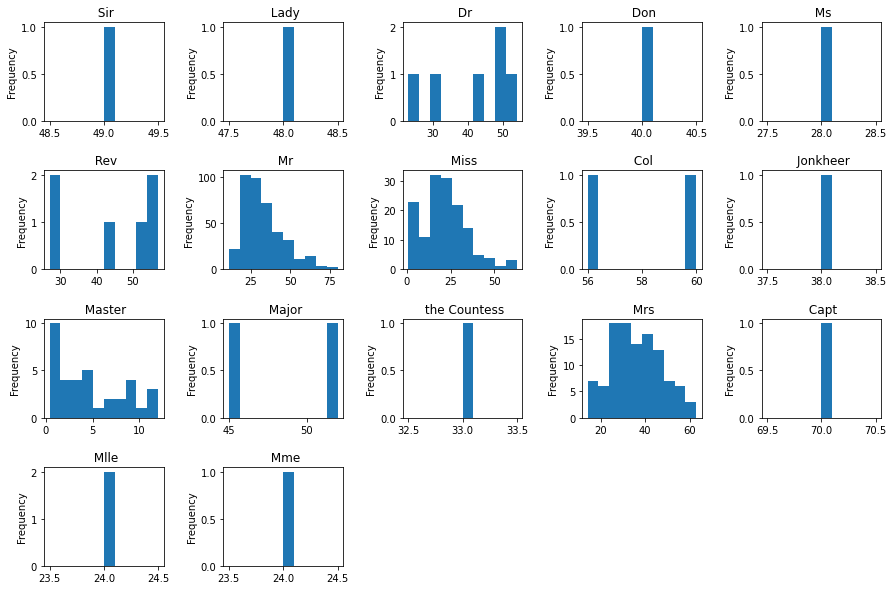

In [78]:
def plot_age_distribution(data, set_titles, plots_per_row=5):
    n = len(set_titles)
    n_rows = n // plots_per_row + 1
    n_cols = plots_per_row
    fig = plt.figure(figsize=(15, 10))

    for (i, title) in enumerate(set_titles):
        plt.subplot(n_rows, n_cols, i+1)
        data_temp = data[data.title==title]
        data_temp.Age.plot.hist()
        plt.title(title)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

plot_age_distribution(data=data, set_titles=set_titles)

There are a few dirty data, such as `Jonkheer`

Check titles of passengers with missing `Age`

In [86]:
mask = data.Age.isnull()
print('titles of passengers with missing Age', set(data[mask].title))

titles of passengers with missing Age {' Dr', ' Mr', ' Miss', ' Master', ' Mrs'}


## Fill `Age` with median in the group

In [170]:
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

def get_title(data):
    np_names = np.array(data.Name)
    titles = []
    for name in np_names:
        family_name = name.split(',')[-1]
        title = family_name.split('.')[0]
        titles.append(title)

    set_titles = set(titles)
    data['Title'] = titles

    return set_titles

data = load_train_data()
get_title(data)
data['Age'] = data.groupby('Title').Age.transform(lambda x: x.fillna(x.median()))

num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
  ])

num_attribs = ["Age", "Fare"]
cat_attribs = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

data = shuffle(data, random_state=42)
data.reset_index(inplace=True, drop=True)
X = full_pipeline.fit_transform(data)
y = data["Survived"].to_numpy()

## Logistic Regression (81.5%)

In [171]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)
score = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
print('accuracy: %.3f'%score.mean())

accuracy: 0.815


An improvement of 0.7%